# Video decomposition via projection onto a Generalized Minkowski Set

Load packages, data

In [ ]:
#background-anomaly separation escalator video with Minkowski decomposition
using Distributed
@everywhere using SetIntersectionProjection
using MAT
using LinearAlgebra
using Statistics

ENV["MPLBACKEND"]="qt5agg"
using PyPlot

#define computational grid structure
@everywhere mutable struct compgrid
  d :: Tuple
  n :: Tuple
end

#select working precision
TF=Float32 #Float32

#load escalator video) (Mablab files for compatibility with matlab only solvers for comparison...)
if isfile("escalator_data.mat") == true
  file     = matopen("escalator_data.mat")
  #file = matopen(joinpath(dirname(pathof(SetIntersectionProjection)), "../examples/Data/escalator_data.mat"))
else
  println("downloading escalator video from http://cvxr.com/tfocs/demos/rpca/escalator_data.mat")
  run(`wget http://cvxr.com/tfocs/demos/rpca/escalator_data.mat`)
  #error("download escalator video from http://cvxr.com/tfocs/demos/rpca/escalator_data.mat")
end
mtrue    = read(file, "X")
n1       = convert(Integer,read(file, "m"))
n2       = convert(Integer,read(file, "n"))
m_mat    = convert(Array{TF,2},mtrue)
m_tensor = convert(Array{TF,3},reshape(mtrue,n1,n2,Integer(200)))

Data preprocessing: subtract the median of each time-frame to compensate partially for lighting conditions

In [2]:
#preprocess data
for i=1:size(m_tensor,3)
  m_tensor[:,:,i].=m_tensor[:,:,i].-median(m_tensor[:,:,i])
end

train - evaluation split of the video. This is different from most low-rank+sparse / rpca type approaches. We use the last 20 frames (without people) to span a subspace to use as a constraint for the backgorund component.

In [ ]:
#split data tensor in a training and evaluation data
m_train      = m_tensor[:,:,181:200] #last 20 frames do not have people -> this should be the background so we learn constraints from it
m_evaluation = m_tensor[:,:,1:180]
m_est        = zeros(TF,size(m_evaluation)) #allocate results

In [ ]:
#define solver options
options=PARSDMM_options()
options.FL=Float32
options=default_PARSDMM_options(options,options.FL)
options.adjust_gamma           = true
options.adjust_rho             = true
options.adjust_feasibility_rho = true
options.Blas_active            = true
options.maxit                  = 100
options.feas_tol               = 0.001
options.obj_tol                = 0.001
options.evol_rel_tol           = 0.00001

set_zero_subnormals(true)
BLAS.set_num_threads(4)
options.parallel         = false
options.feasibility_only = false
options.zero_ini_guess   = true
options.Minkowski        = true

Set up computational grid and constraints

In [5]:
#computational grid for the training images (all images assumed to be on the same grid here)
comp_grid_eval  = compgrid((1f0,1f0,1f0),(size(m_evaluation,1),size(m_evaluation,2), size(m_evaluation,3)))
comp_grid_train = compgrid((1f0,1f0,1f0),(size(m_train,1),size(m_train,2), size(m_train,3)))

#initialize constraint dictionaries
constraint_background = Vector{SetIntersectionProjection.set_definitions}()
constraint_anomaly    = Vector{SetIntersectionProjection.set_definitions}()
constraint_sum        = Vector{SetIntersectionProjection.set_definitions}()

#observe and define bound constraints for background
  #bounds:
  m_min     = minimum(m_train,dims=3)
  m_min     = vec(repeat(m_min[:,:,:],outer=[1,1,comp_grid_eval.n[3]])) .- 40.0
  m_max     = maximum(m_train,dims=3)
  m_max     = vec(repeat(m_max[:,:,:],outer=[1,1,comp_grid_eval.n[3]])) .+ 40.0
  set_type  = "bounds"
  TD_OP     = "identity"
  app_mode  = ("matrix","")
  custom_TD_OP = ([],false)
  push!(constraint_background, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

  #subspace constraints on each z-slice of the tensor
  m_min    = 0.0
  m_max    = 0.0
  set_type = "subspace"
  TD_OP     = "identity"
  A = m_train
  A = reshape(A,size(A,1)*size(A,2),size(A,3))
  F = svd(A)
  app_mode  = ("slice","z")
  custom_TD_OP = (F.U,true)
  push!(constraint_background, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#set bound constraints for sum
  m_min     = minimum(m_tensor) .- 10f0
  m_max     = maximum(m_tensor) .+ 10f0
  set_type  = "bounds"
  TD_OP     = "identity"
  app_mode  = ("matrix","")
  custom_TD_OP = ([],false)
  push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#define constraints for anomaly
  # #set bound constraints for anomaly (this should be bounds-sum - bounds-background)
  # m_min     = minimum(m_tensor) .- 10f0 .- constraint_background[1].min .- 20.0
  # m_max     = maximum(m_tensor) .- 10f0 .- constraint_background[1].max .+ 20.0
  # set_type  = "bounds"
  # TD_OP     = "identity"
  # app_mode  = ("matrix","")
  # custom_TD_OP = ([],false)
  # push!(constraint_anomaly, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

  #set maximum of nonzero pixels in anomaly component for every time-frame
  m_min     = 0
  m_max     = Integer(round(0.25*comp_grid_eval.n[1]*0.25*comp_grid_eval.n[2]))
  set_type  = "cardinality"
  TD_OP     = "identity"
  app_mode  = ("slice","z")
  custom_TD_OP = ([],false)
  push!(constraint_anomaly, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

  #set maximum of nonzero jumps (x) in pixel values in anomaly component for every time-frame
  m_min     = 0
  m_max     = 4*12*10
  set_type  = "cardinality"
  TD_OP     = "D_x"
  app_mode  = ("slice","z")
  custom_TD_OP = ([],false)
  push!(constraint_anomaly, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

  #set maximum of nonzero jumps (xy in pixel values in anomaly component for every time-frame
  m_min     = 0
  m_max     = 22*2*10
  set_type  = "cardinality"
  TD_OP     = "D_y"
  app_mode  = ("slice","z")
  custom_TD_OP = ([],false)
  push!(constraint_anomaly, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#set up constraints, precompute some things and define projector
(P_sub_sum,TD_OP_sum,set_Prop_sum) = setup_constraints(constraint_sum,comp_grid_eval,options.FL)
(P_sub_c1,TD_OP_c1,set_Prop_c1)    = setup_constraints(constraint_background,comp_grid_eval,options.FL)
(P_sub_c2,TD_OP_c2,set_Prop_c2)    = setup_constraints(constraint_anomaly,comp_grid_eval,options.FL)

(TD_OP,set_Prop,AtA,l,y) = PARSDMM_precompute_distribute_Minkowski(TD_OP_c1,TD_OP_c2,TD_OP_sum,set_Prop_c1,set_Prop_c2,set_Prop_sum,comp_grid_eval,options)

P_sub=deepcopy(P_sub_c1);
append!(P_sub,P_sub_c2)
append!(P_sub,P_sub_sum)

options.rho_ini = [1.0f0]
options.rho_ini = ones(length(TD_OP))*options.rho_ini[1]
for i=1:length(options.rho_ini)
  if set_Prop.ncvx[i]==true
    options.rho_ini[i]=0.1f0
  end
end



In [ ]:
#compute generalized Minkowski decomposition
@time (v_decomposition,log_PARSDMM,dummy1,dummy2) = PARSDMM(vec(m_evaluation),AtA,TD_OP,set_Prop,P_sub,comp_grid_eval,options);
@time (v_decomposition,log_PARSDMM,dummy1,dummy2) = PARSDMM(vec(m_evaluation),AtA,TD_OP,set_Prop,P_sub,comp_grid_eval,options);

Plot results

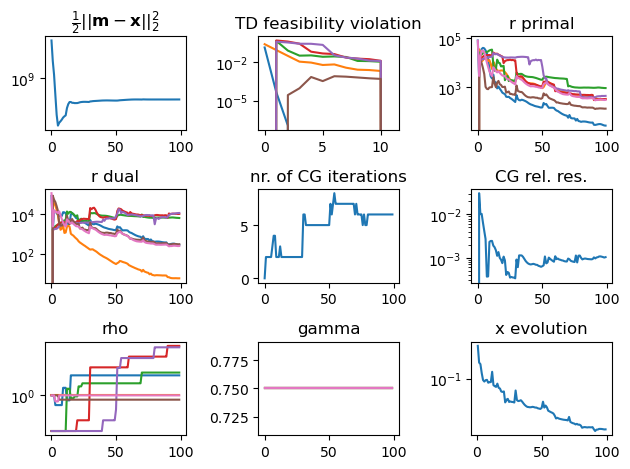

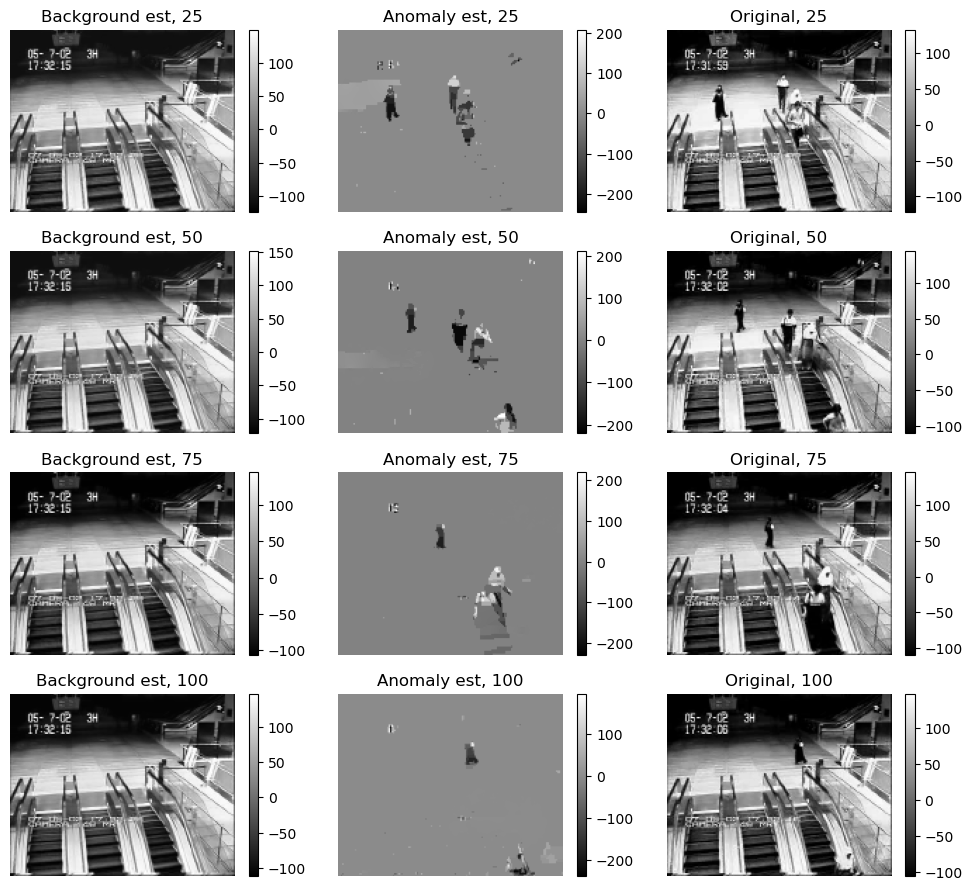

In [7]:
figure();
subplot(3, 3, 3);semilogy(log_PARSDMM.r_pri)          ;title("r primal")
subplot(3, 3, 4);semilogy(log_PARSDMM.r_dual)         ;title("r dual")
subplot(3, 3, 1);semilogy(log_PARSDMM.obj)            ;title(L"$ \frac{1}{2} || \mathbf{m}-\mathbf{x} ||_2^2 $")
subplot(3, 3, 2);semilogy(log_PARSDMM.set_feasibility);title("TD feasibility violation")
subplot(3, 3, 5);plot(log_PARSDMM.cg_it)              ;title("nr. of CG iterations")
subplot(3, 3, 6);semilogy(log_PARSDMM.cg_relres)      ;title("CG rel. res.")
subplot(3, 3, 7);semilogy(log_PARSDMM.rho)            ;title("rho")
subplot(3, 3, 8);plot(log_PARSDMM.gamma)              ;title("gamma")
subplot(3, 3, 9);semilogy(log_PARSDMM.evol_x)         ;title("x evolution")
tight_layout()

#plot
m_est_background = v_decomposition[1:prod(comp_grid_eval.n)]
m_est_anomaly    = v_decomposition[1+prod(comp_grid_eval.n):end]
m_est_sum        = m_est_background + m_est_anomaly

m_est_background = reshape(m_est_background,comp_grid_eval.n)
m_est_anomaly    = reshape(m_est_anomaly,comp_grid_eval.n)
m_est_sum        = reshape(m_est_sum,comp_grid_eval.n)

figure(figsize=(10,9))
for i=1:4
  subplot(4,3,(i-1)*3+1);imshow(m_est_background[:,:,i*25],cmap="gray");axis("off");colorbar();title(string("Background est, ",i*25)) #title("training image", fontsize=10)
  subplot(4,3,(i-1)*3+2);imshow(m_est_anomaly[:,:,i*25],cmap="gray");axis("off");colorbar();title(string("Anomaly est, ",i*25))
  #subplot(4,4,i+8);imshow(m_est_sum[:,:,i*25],cmap="gray");axis("off");colorbar();;title(string("sum, ",i*25))
  subplot(4,3,(i-1)*3+3);imshow(m_evaluation[:,:,i*25],cmap="gray");axis("off");colorbar();;title(string("Original, ",i*25))
end
tight_layout()
savefig("escalator_decomposition.png")

To compare results with another method (split-SPCP), you need to run the matlab code from the repository cited below, save the "L" and "S" matrices as .mat files. The code below loads, reshapes and plots the comparision

In [8]:
# ########### Plot results from another method #############
# #run example in MatLab: https://github.com/stephenbeckr/fastRPCA/blob/master/demos/demo_escalatorVideo.m
# #figures below are the result of "split_SPCP" in the above script
# file     = matopen("L.mat")
# L = read(file,"L") #low rank component
# file     = matopen("S.mat")
# S = read(file,"S") #sparse component

# L = reshape(L,comp_grid_eval.n[1],comp_grid_eval.n[2],200)
# S = reshape(S,comp_grid_eval.n[1],comp_grid_eval.n[2],200)

# figure(figsize=(10,9))
# for i=1:4
#   subplot(4,3,(i-1)*3+1);imshow(L[:,:,i*25],cmap="gray");axis("off");colorbar();title(string("Background sSPCP, ",i*25)) #title("training image", fontsize=10)
#   subplot(4,3,(i-1)*3+2);imshow(S[:,:,i*25],cmap="gray");axis("off");colorbar();title(string("Anomaly sSPCP, ",i*25))
#   #subplot(4,4,i+8);imshow(m_est_sum[:,:,i*25],cmap="gray");axis("off");colorbar();;title(string("sum, ",i*25))
#   subplot(4,3,(i-1)*3+3);imshow(m_evaluation[:,:,i*25],cmap="gray");axis("off");colorbar();;title(string("Original, ",i*25))
# end
# tight_layout()
# savefig("escalator_decomposition_splitSPCP.png")

# #Plot results of both methods in one figure
# figure(figsize=(10,10))
# for i=1:4
#   subplot(5,4,i);imshow(m_evaluation[:,:,i*25],cmap="gray");axis("off");;title(string("Original, ",i*25))
#   subplot(5,4,i+4);imshow(m_est_background[:,:,i*25],cmap="gray");axis("off");title(string("Background gMinkowski, ",i*25)) #title("training image", fontsize=10)
#   subplot(5,4,i+8);imshow(m_est_anomaly[:,:,i*25],cmap="gray");axis("off");title(string("Anomaly gMinkowski, ",i*25))
#   subplot(5,4,i+12);imshow(L[:,:,i*25],cmap="gray");axis("off");title(string("Background sSPCP, ",i*25)) #title("training image", fontsize=10)
#   subplot(5,4,i+16);imshow(S[:,:,i*25],cmap="gray");axis("off");title(string("Anomaly sSPCP, ",i*25))
# end
# tight_layout()
# savefig("escalator_decomposition_allresults.png")